In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
data = pd.read_csv('student-mat.csv', sep=';')  # ';' is the separator in the file

In [4]:
print(data.columns)  # Check the first few rows
print(data.info())  # Look at column data typesdata = pd.get_dummies(data, drop_first=True)


Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null 

In [8]:
data = pd.get_dummies(data, drop_first=True)

/var/folders/xf/5j_h5w0j48324_dgpfsgb4sm0000gn/T/ipykernel_2676/158501165.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, orient='h', palette='coolwarm')


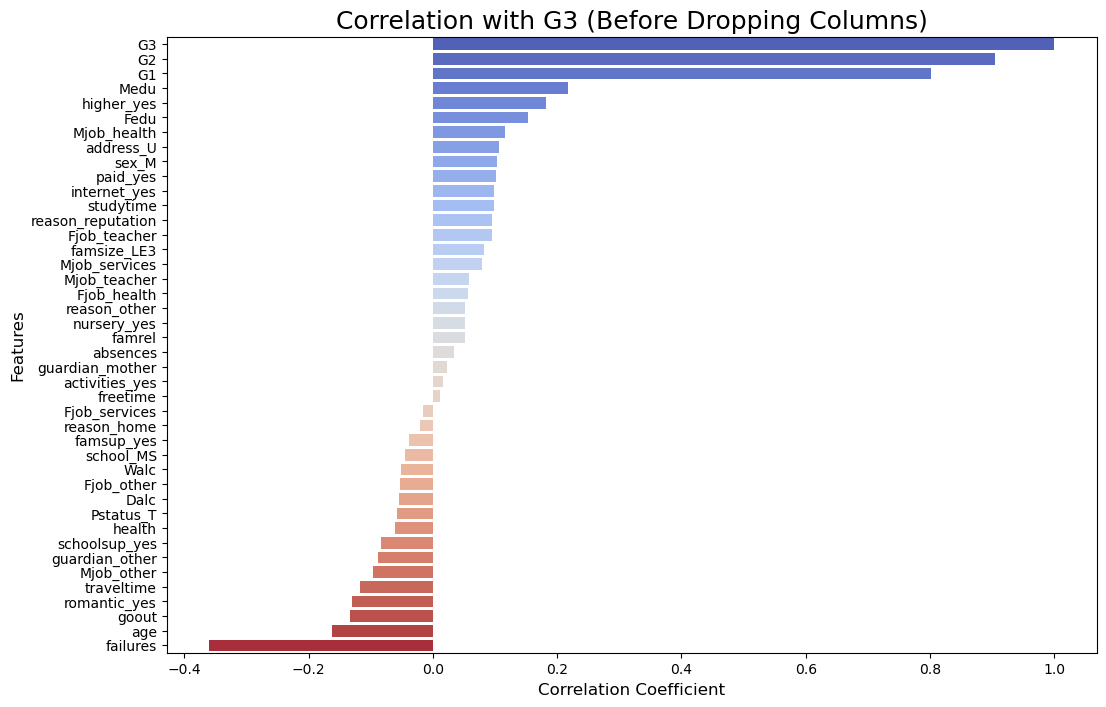

In [10]:
# All features
correlation_with_target = data.corr()['G3'].sort_values(ascending=False)

#Horizontal Barplot BEFORE Dropping Columns
plt.figure(figsize=(12, 8))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, orient='h', palette='coolwarm')
plt.title('Correlation with G3 (Before Dropping Columns)', fontsize=18)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [12]:
# Select important features
important_features = ['G1', 'G2', 'absences']  # Adjust based on your findings

X = data[important_features]  # Features
y = data['G3']  # Target variable

In [14]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Train the Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [18]:
import joblib

In [20]:
# Save the trained model
joblib.dump(model, 'student_grade_predictor.pkl')

['student_grade_predictor.pkl']

In [22]:
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)

print(f"R2 Score: {r2}")

# Evaulation as percentages
r2_cal = r2 * 100
print(f"R2 Score: {r2_cal:.2f}%")

R2 Score: 0.8330528921883602
R2 Score: 83.31%


/var/folders/xf/5j_h5w0j48324_dgpfsgb4sm0000gn/T/ipykernel_2676/2050206687.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=importance_sorted, x=feature_names_sorted, palette="coolwarm")  # Bars in sorted order


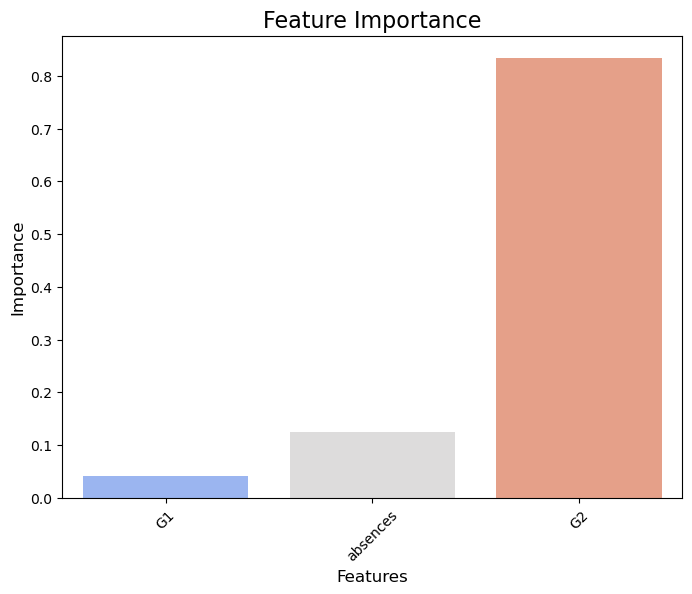

In [24]:
# Plot feature importance
importance = model.feature_importances_
feature_names = X.columns


# Sort the feature importance values and corresponding feature names
sorted_indices = importance.argsort()  # Get indices to sort importance
importance_sorted = importance[sorted_indices]  # Sort importance values
feature_names_sorted = feature_names[sorted_indices]  # Sort feature names accordingly

# Plot sorted feature importance
plt.figure(figsize=(8, 6))
sns.barplot(y=importance_sorted, x=feature_names_sorted, palette="coolwarm")  # Bars in sorted order
plt.title("Feature Importance", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Importance", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.show()

In [26]:
# Load the model
model = joblib.load('student_grade_predictor.pkl')

print(X.columns)

Index(['G1', 'G2', 'absences'], dtype='object')


In [ ]:
from flask import Flask, render_template, request
import joblib

# Initialize Flask app
app = Flask(__name__)

# Load the saved model
model = joblib.load('student_grade_predictor.pkl')

# Define feature ranges based on model training data
G1_range = (0, 20)  # Adjust based on your training data
G2_range = (0, 20)  # Adjust based on your training data
absences_range = (0, 93)  # Adjust based on your training data

# Define the home route
@app.route("/", methods=["GET", "POST"])
def index():
    prediction = None

    if request.method == "POST":
        # Get user inputs
        G1 = int(request.form.get("G1"))
        G2 = int(request.form.get("G2"))
        absences = int(request.form.get("absences"))

        # Prepare the input data as a DataFrame
        new_data = pd.DataFrame([{
            'G1': G1,
            'G2': G2,
            'absences': absences
        }])

        # Ensure feature order matches the training data
        new_data = new_data[['G1', 'G2', 'absences']]  # Adjust if necessary

        # Make the prediction
        prediction = model.predict(new_data)[0]

    return render_template("index.html", prediction=prediction, G1_range=G1_range, G2_range=G2_range, absences_range=absences_range)

# Run the app
if __name__ == "__main__":
    app.run(debug=True, port=5000)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:8000
Press CTRL+C to quit
 * Restarting with watchdog (fsevents)
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

SystemExit: 1

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
